In [1]:
import sys, os
import theano
import scipy
from collections import OrderedDict
from copy import deepcopy
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from theano import shared
import theano.tensor as tt
from theano.sandbox.rng_mrg import MRG_RandomStreams
import pymc3 as pm
from pymc3 import math as pmmath
from pymc3 import Dirichlet
from pymc3.distributions import Interpolated
from pymc3.distributions.transforms import t_stick_breaking
plt.style.use('seaborn-darkgrid')
from tqdm import tqdm
from collections import Counter
import scanpy as sc
import pandas as pd
sc.settings.autosave=False
sc.settings.autoshow=True
import anndata
import re


# ambiaint test

/home/mt/code/utils/miniconda3/envs/pymc/lib/python3.7/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../../utils/miniconda3/envs/pymc/lib/python3.7/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/home/mt/code/utils/miniconda3/envs/pymc/lib/python3.7/site-packages/numba/compiler.py:725: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../../utils/miniconda3/envs/pymc/lib/python3.7/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

  self.func_ir.loc))
/home/mt/code/utils/miniconda3/envs/pymc/lib/p

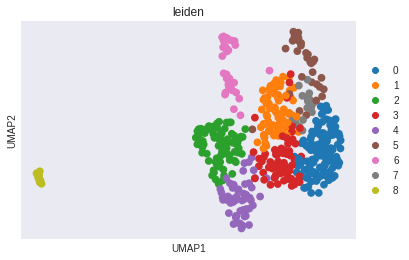

In [2]:
#limit for memory
maxgenes=1000
ncells=500
headpath=os.path.expanduser("/home/mt/Downloads/")
h5adpath=os.path.join(headpath,'MultiseqRaw.h5ad')
#Load any 10x dataset

adata=sc.read_h5ad(h5adpath)
adata._inplace_subset_obs(adata.obs['batch']=='0')
sc.pp.filter_cells(adata,min_counts=15,inplace=True)
cells=np.random.choice(adata.obs.index,ncells,replace=False)
adata._inplace_subset_obs(cells)
adata._inplace_subset_var((-adata.X).sum(0).A1.argsort()[0:min(maxgenes,adata.shape[1])])

sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=min(maxgenes,4000))
sc.pp.scale(adata, max_value=10)
#sc.pp.regress_out(adata,'n_counts')

sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)
sc.pl.umap(adata,color='leiden')
clusters=adata.obs['leiden']

In [3]:
#Reload fresh dataset
adata=sc.read_h5ad(h5adpath)
adata._inplace_subset_obs(cells)
#limit genes to top maxgenes expressed 
adata._inplace_subset_var((-adata.X).sum(0).A1.argsort()[0:min(maxgenes,adata.shape[1])])
adata.obs['leiden']=clusters
freshadata=adata.copy()

In [4]:
#mean and sd of ambient gaussian
ambmu,ambsd=2.0,.4
#K topics/modules
K=10
n_iterations=120

In [5]:
#Get mixtures of genes in each cluster
clusterphis=[]
for c in set(clusters):
    clusterphis.append(adata[adata.obs['leiden']==c,:].X.sum(0).A1)
clusterphis=np.matrix(clusterphis)
clusterphis=clusterphis/(clusterphis.sum(1))

#Construct an ambient fraction that is mixture of clusters
def Stick_Breaking(num_weights, alpha):
    betas = np.random.beta(1, alpha, size=num_weights)
    betas[1:] *= np.cumprod(1 - betas[:-1])
    return betas
ambprops=Stick_Breaking(len(set(clusters)),1)
np.random.shuffle(ambprops)
ambcounts=[int(x) for x in 10**np.random.normal(ambmu,ambsd,adata.shape[0])]
print(ambprops)
sum(ambprops)


[1.30942165e-04 1.01518529e-02 3.24488740e-01 9.93567315e-02
 2.05217564e-03 1.54782003e-01 3.84645124e-01 2.28101288e-02
 1.43159695e-03]


0.999849294982156

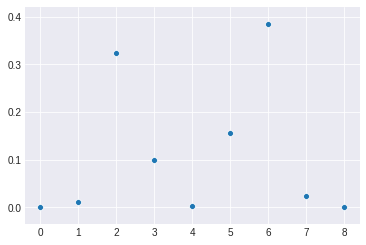

In [6]:
sns.scatterplot(list(range(len(ambprops))),ambprops)

In [7]:
phiAmbient=(ambprops*clusterphis).A1
phiAmbient=phiAmbient/phiAmbient.sum()
phiAmbientDict=dict(zip(list(adata.var.index), phiAmbient))
tmpmat=scipy.sparse.csr_matrix(adata.shape)
for ci,c in tqdm(enumerate(adata.obs.index)):
    countadd=Counter(np.random.choice(list(range(len(phiAmbient))),replace=True,size=ambcounts[ci],p=phiAmbient))
    tmpmat[ci,list(countadd.keys())]=list(countadd.values())

500it [00:01, 452.86it/s]


In [8]:
adata.X.sum()

1037042.0

In [9]:
adata.X=adata.X+tmpmat

In [10]:
(adata.X-tmpmat).sum()

1037042.0

In [11]:
np.corrcoef(tmpmat.sum(0).A1,phiAmbient)

array([[1.        , 0.99953287],
       [0.99953287, 1.        ]])

In [22]:
feature_names=list(adata.var.index)
tf=adata.X
n_tokens = np.sum(tf[tf.nonzero()])
print('Number of tokens in training set = {}'.format(n_tokens))
print('Sparsity = {}'.format(
    len(tf.nonzero()[0]) / float(tf.shape[0] * tf.shape[1])))

model1 = pm.Model()
(D,V)=tf.shape
print(D,V)
#Alpha prior for theta topic over cell distribution
alpha = np.ones((D, K))*.1
alpha[:,K-1]=ambmu/tf.sum(1).A1
#beta prior for gene over topic distribution
beta = np.ones((K-1, V))*.1
sparse_array=shared(np.array([tf.nonzero()[0],tf.nonzero()[1],tf.data]).T.astype('int32'))
tt.cast(sparse_array,'int32')
rowsums=shared(np.sum(tf,axis=1).T)
sumall=shared(np.sum(tf))
def lognormpdf(mean, sd):
    import math
    def internalnorm(x):
        var = float(sd)**2
        denom = tt.log(2*math.pi*var)*.5
        num = -(x-float(mean))**2/(2*var)
        return(num-denom)
    return internalnorm
ambient=lognormpdf(ambmu,ambsd)

def _norm_logpdf(x):
    _norm_pdf_logC=tt.log(tt.sqrt(2*np.pi))
    return -x**2 / 2.0 - _norm_pdf_logC

def lognormpdf(mean, sd,df):
    import math
    def internalnorm(x):
        df2=x.shape[1]-1
        sd2=x.std()
        Fstat=sd2/sd
        n = 1.0 * df
        m = 1.0 * df2
        lPx = m/2 * tt.log(m) + n/2 * tt.log(n) + (n/2 - 1) * tt.log(Fstat)
        lPx -= ((n+m)/2) * np.log(m + n*Fstat) + (tt.gammaln(n/2)+tt.gammaln(m/2)-tt.gammaln((n+m)/2))
        tt.printing.Print('l')(lPx)
        #fp=scipy.stats.f.logpdf(Fstat,df,df2)
        pooledSE = tt.sqrt(sd**2/df + sd2**2/df2)
        z = (tt.mean(x)-mean)/pooledSE
        pval = _norm_logpdf(z)
        tt.printing.Print('l')(pval)
        var = float(sd)**2
        denom = tt.log(2*math.pi*var)*.5
        num = -(x-float(mean))**2/(2*var)
        return(lPx+pval+tt.sum(num-denom))
    return internalnorm
#ambient=lognormpdf(ambmu,ambsd,90000)


def log_lda(theta, phi,value,rowsums,sumall,phiAmbient=None):
    if phiAmbient is not None:
        phi=tt.concatenate([phi,phiAmbient],axis=0)
    else:
        phi=phi
    #ll = value[:,2] * pm.math.logsumexp(tt.log(theta[value[:,0].astype('int32')]+1e-9)+ tt.log(phi.T[value[:,1].astype('int32')]+1e-9),axis=1).ravel()                                                                  
    #ambientll=ambient(tt.log10((rowsums)*(theta[:,theta.shape[1]-1])+1e-9))
    ll = value[:,2] * pm.math.logsumexp(tt.log(theta[value[:,0].astype('int32')]+1e-10)+ tt.log(phi.T[value[:,1].astype('int32')]+1e-10),axis=1).ravel()                                                                  
    ambientll=ambient(tt.log10((rowsums+1e-10)*(theta[:,theta.shape[1]-1]+1e-10)))
    #return(tt.sum(ll)+ ambientll)
    #tt.printing.Print('l')(tt.sum(ambientll))
    #return((ambientll.shape[1]*(tt.sum(ll)/sumall) + (tt.sum(ambientll))))
    #return tt.sum(ll) + tt.sum(ambientll)*(sumall/rowsums.shape[1])
    #return(tt.sum(ll)+ tt.sum(ambientll)*2)
    #return(((tt.sum(ll)/sumall) + (ambientll)/theta.shape[0]))
    #return(((tt.sum(ll)/sumall) + (2*tt.sum(ambientll)/ambientll.shape[1]))*(sumall*ambientll.shape[1]))
    return((1e7*(tt.sum(ll)/(sumall*beta.shape[1])) + (tt.sum(ambientll)/ambientll.shape[1])*3e3))
    #return (tt.sum(ll)-sumall) + (tt.sum(ambientll)-rowsums.shape[1])

with model1: 
    theta = pm.Dirichlet("theta", a=alpha, shape=(D, K), transform=t_stick_breaking(1e-9))#.astype('float32')
    #Kth topic is fixed as ambient distribution, therefore not learned
    phi = pm.Dirichlet("phi", a=beta, shape=(K-1, V), transform=t_stick_breaking(1e-9))#.astype('float32')
    doc = pm.DensityDist('doc', log_lda, observed=dict(theta=theta,
        phi=phi,
        value=sparse_array,phiAmbient=np.matrix([phiAmbientDict[x] for x in feature_names]),rowsums=rowsums,sumall=sumall))

eta = .5
s = shared(eta)
def reduce_rate(a, h, i):
    s.set_value(eta/((i/200)+1)) 

Number of tokens in training set = 1113188.0
Sparsity = 0.522034
500 1000


In [ ]:
with model1:    
    #Inference learning methods appear about equivalent
    #inference = pm.ADVI()
    #inference = pm.FullRankADVI()
    inference=pm.variational.NFVI()
    approx = pm.fit(n=1000,method= inference,obj_optimizer=pm.adam(learning_rate=s),callbacks=[pm.callbacks.CheckParametersConvergence(diff='absolute')])

    

Average Loss = 88,415:  27%|██▋       | 271/1000 [01:16<04:39,  2.60it/s]

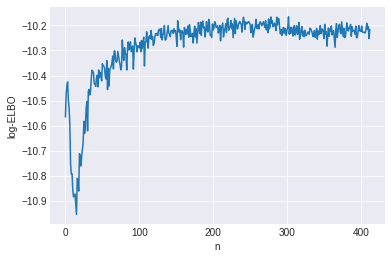

Correlation between actual ambient and predicted ambient counts
-0.010421128289398065
 actual ambient and predicted ambient count distributions


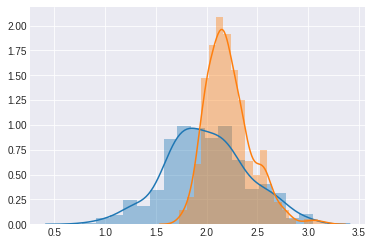

Actual vs predicted


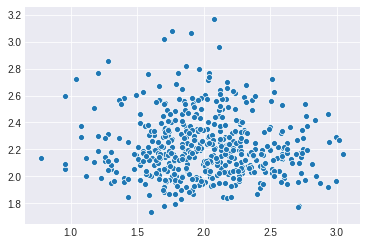

In [19]:

tr1 = approx.sample(draws=500)
advi_elbo = pd.DataFrame(
    {'log-ELBO': -np.log(approx.hist),
     'n': np.arange(approx.hist.shape[0])})
plt.clf()
sns.lineplot(y='log-ELBO', x='n', data=advi_elbo)
#plt.savefig(os.path.join(sc.settings.figdir,'ELBO.png'))
plt.show()
theta=tr1['theta'].mean(0)
print('Correlation between actual ambient and predicted ambient counts')
print(scipy.stats.spearmanr(np.log10(ambcounts),np.log10(adata.X.sum(1).A1*theta[:,9]))[0])
print(' actual ambient and predicted ambient count distributions')
sns.distplot(np.log10(ambcounts))
sns.distplot(np.log10(adata.X.sum(1).A1*theta[:,9]))
plt.show()
print('Actual vs predicted')
sns.scatterplot(np.log10(ambcounts),np.log10(adata.X.sum(1).A1*theta[:,9]))
plt.show()
theta=anndata.AnnData(theta,var=pd.DataFrame(index=['lda_'+str(i) for i in range(K) ]),obs=pd.DataFrame(index=list(adata.obs.index)))
for i in range(theta.shape[1]):
    freshadata.obs['lda_'+str(i)]=theta[:,i].X

# In[15]:
phi=tr1['phi'].mean(0)
phi=anndata.AnnData(phi,var=pd.DataFrame(index=feature_names),obs=pd.DataFrame(index=['lda_'+str(i) for i in range(K-1) ]))

for i in range(phi.shape[0]):
    freshadata.var['lda_'+str(i)]=0
    freshadata.var.loc[list(phiAmbientDict.keys()),'lda_'+str(i)]=phi[i,:][:,list(phiAmbientDict.keys())].X
freshadata.var['lda_'+str(K-1)]=0
#Resort indices so the ones we're subtracting from are listed first
freshadata.var.loc[list(phiAmbientDict.keys()),'lda_'+str(K-1)]=list(phiAmbientDict.values())
fullinds=list(freshadata.var.index)
[fullinds.insert(0, fullinds.pop(fullinds.index(i))) for i in feature_names[::-1]]
freshadata=freshadata[:,fullinds]
#Reassign phiAmbient now that matrix is reordered
phiAmbientDict=dict(zip(list(freshadata.var.index),list(freshadata.var['lda_'+str(K-1)])))


The blue and orange hists above change depending upon training. For some reason scaling up the log likelihood biases training against the normal likelihood term, leading to convergence on only the mean...

saving figure to file ./figures/umapAfterLeiden.pdf


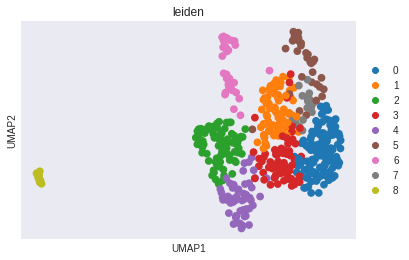

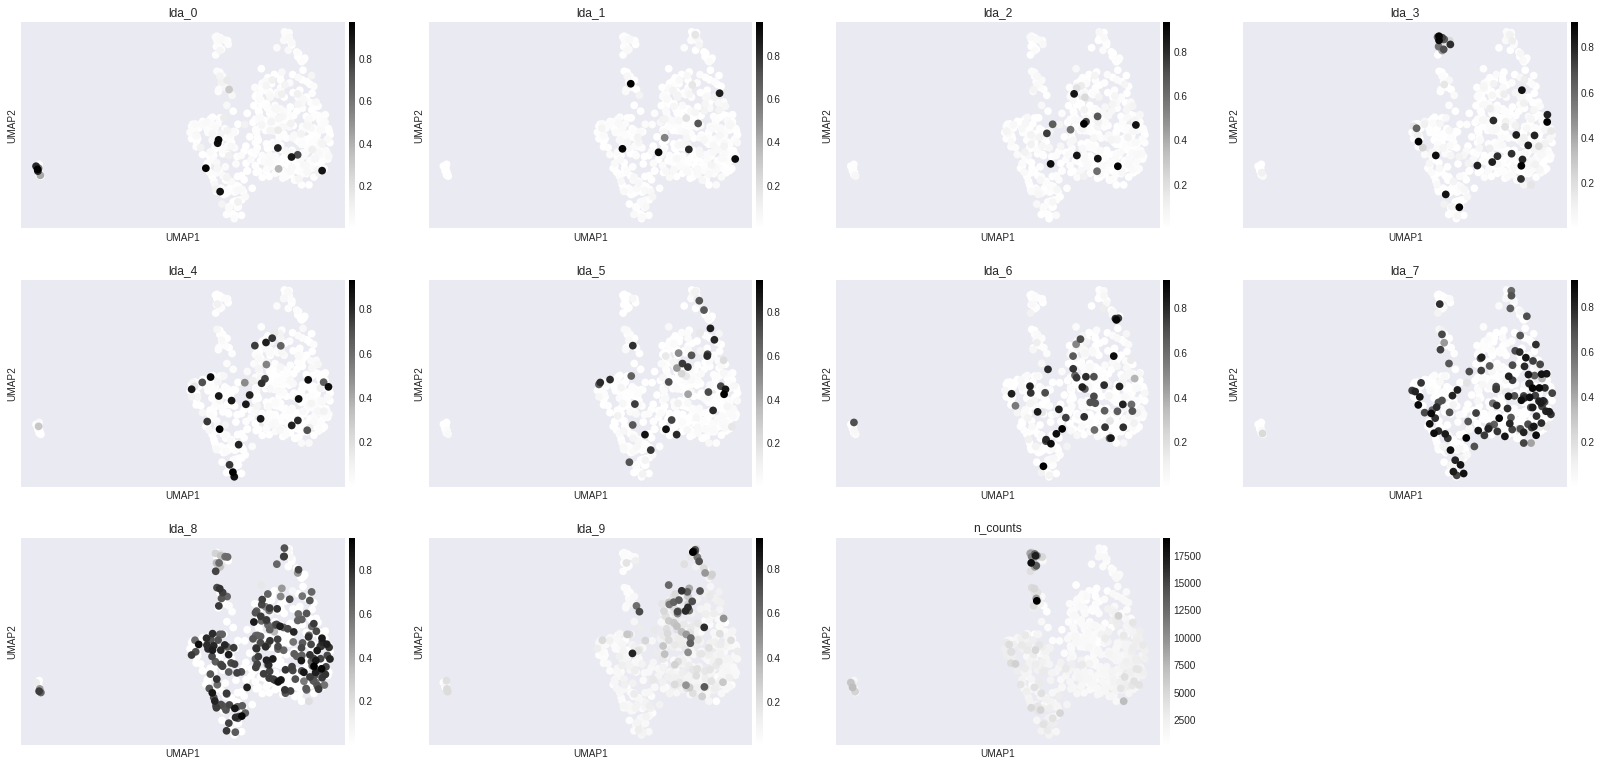

In [20]:
freshadata.raw=freshadata
#sc.pp.filter_genes(freshadata,min_counts=2,inplace=True)
sc.pp.filter_cells(freshadata,min_counts=0,inplace=True)
sc.pp.normalize_total(freshadata, target_sum=1e4)
sc.pp.log1p(freshadata)
sc.pp.highly_variable_genes(freshadata,n_top_genes=min(adata.shape[1],4000),inplace=True)
sc.pp.scale(freshadata, max_value=10)
sc.pp.pca(freshadata)
sc.pp.neighbors(freshadata)
sc.tl.umap(freshadata)
sc.tl.leiden(freshadata)
sc.pl.umap(freshadata, color=['leiden'],save="AfterLeiden")
freshadata.X=freshadata.raw.X
sc.pl.umap(freshadata, color=['lda_0','lda_1','lda_2','lda_3','lda_4','lda_5','lda_6','lda_7','lda_8','lda_9','n_counts'])

In [21]:
#Generative process to remove counts
tmpmat3=scipy.sparse.csr_matrix(freshadata.shape)
theta=np.matrix(freshadata.obs.loc[:,['lda' in x for x in freshadata.obs.columns]])
phi=np.matrix(freshadata.var.loc[:,['lda' in x for x in freshadata.var.columns]])
for ci,c in tqdm(enumerate(freshadata.obs.index)):
    farow=freshadata[c,:].X
    rowinds=farow.nonzero()[0]
    countz=farow[rowinds]
    rowtxp=(theta[ci,0:(K-1)]*phi[:,0:(K-1)].T).A1 #memory saving #txp[ci,:].A1
    rowtxpamb=(theta[ci,(K-1)]*phi[:,(K-1)].T).A1
    indmultiset=[[rowinds[i]]*int(countz[i]) for i in range(len(countz))]
    vals = np.array([item for sublist in indmultiset for item in sublist])
    phimultiset=[[rowtxpamb[rowind]/countz[i]]*int(countz[i]) for i,rowind in enumerate(rowinds)]
    pvals = np.array([item for sublist in phimultiset for item in sublist])
    phimultiset=[[rowtxp[rowind]+rowtxpamb[rowind]+1e-10]*int(countz[i]) for i,rowind in enumerate(rowinds)]
    pvalsdenom = np.array([item for sublist in phimultiset for item in sublist])
    pvals=pvals/(pvalsdenom)
    vals=vals[pvals>0]
    pvals=pvals[pvals>0]
    if len(vals)>0:
        #Select counts based on phiAmbient
        cellcount=np.sum(freshadata[c,:][:,feature_names].X)
        countremove=Counter(np.random.choice(vals,replace=False,size=min(len(vals),int(theta[ci,theta.shape[1]-1]*cellcount)),p=np.array(pvals)/sum(pvals))) 
        tmpmat3[ci,list(countremove.keys())]=list(countremove.values())


0it [00:00, ?it/s]


IndexError: Unknown index 0 of type <class 'numpy.int64'>

In [16]:
#Can remove tmpmat3 from adata.X here

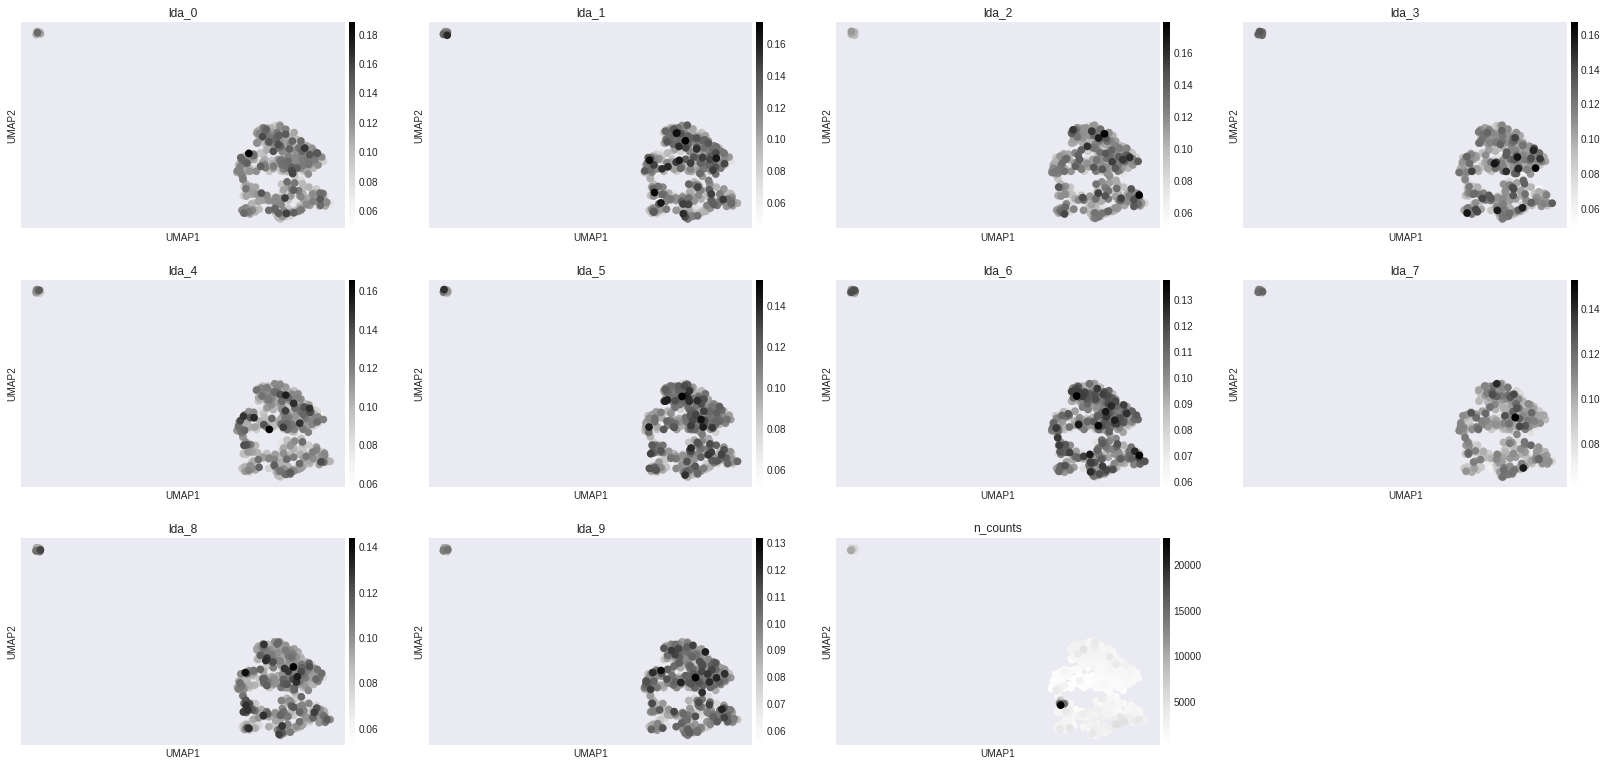

In [25]:
sc.pl.umap(freshadata, color=['lda_0','lda_1','lda_2','lda_3','lda_4','lda_5','lda_6','lda_7','lda_8','lda_9','n_counts'])